Step 0: Install and Import

In [ ]:
!pip install transformers datasets torch scikit-learn matplotlib seaborn -q

import torch
import numpy as np
import pandas as pd
from transformers import GPT2LMHeadModel, GPT2Tokenizer
from datasets import load_dataset
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import AgglomerativeClustering
from sklearn.manifold import TSNE
from scipy.stats import ttest_ind
import warnings
import gc
from collections import defaultdict

warnings.filterwarnings('ignore')
torch.manual_seed(42)
np.random.seed(42)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"\n✓ Using device: {device}")



✓ Using device: cuda


PART 1: SPARSE CIRCUIT DISCOVERY


STEP 1: LOADING MODEL AND DATA
✓ Model: 81.9M parameters
✓ Loaded 500 samples

STEP 2: COLLECTING ACTIVATIONS
✓ Collected activations from 500 samples

STEP 3: IDENTIFYING SPARSE NEURONS
✓ Mean sparsity: 0.357

STEP 4: DISCOVERING CIRCUITS
✓ Sparse activation matrix: (500, 76)
✓ Discovered 5 circuits
  Circuit 4: 55 neurons
  Circuit 1: 5 neurons
  Circuit 3: 4 neurons
  Circuit 2: 4 neurons
  Circuit 0: 8 neurons

STEP 5: CREATING VISUALIZATIONS


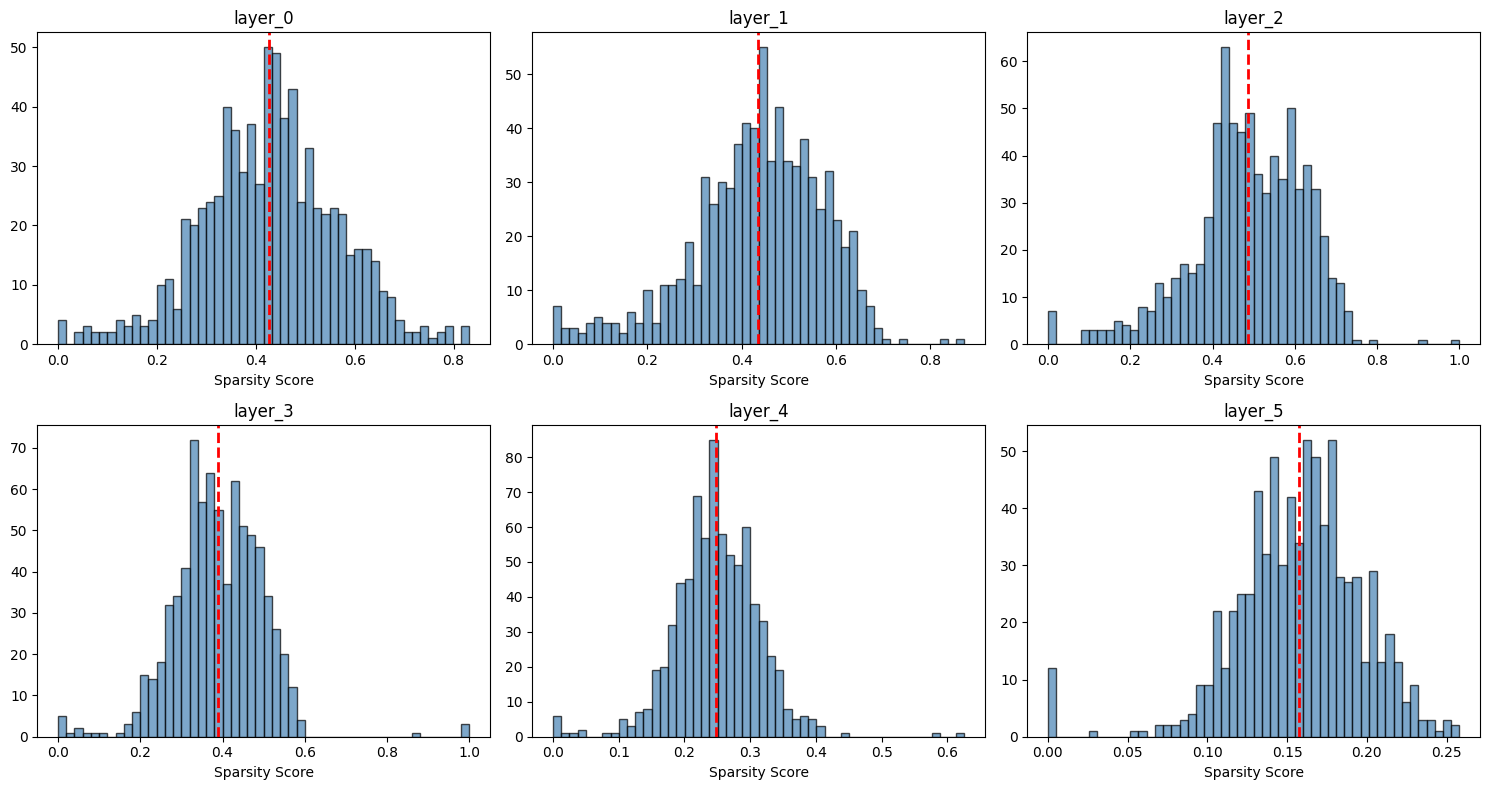

✓ Saved: sparsity_distribution.png


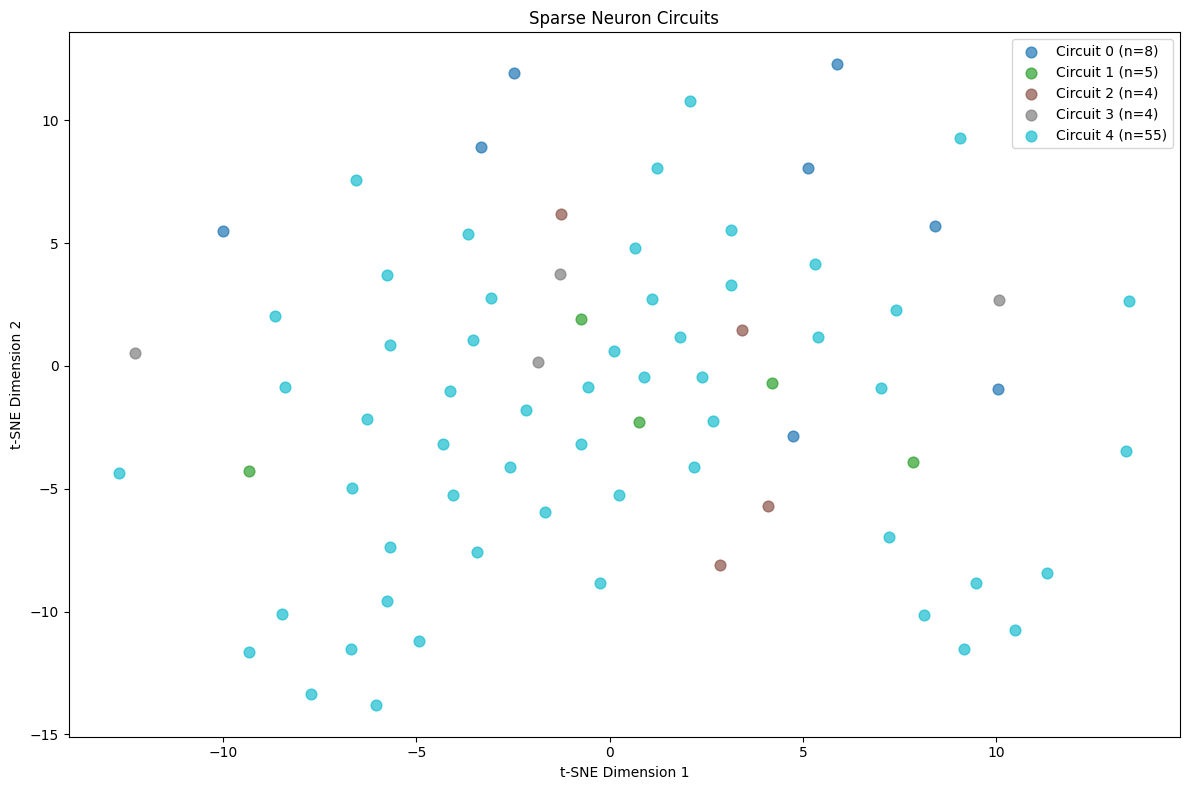

✓ Saved: circuits_tsne.png


In [ ]:
# STEP 1: Load Model and Data
print("\n" + "="*70)
print("STEP 1: LOADING MODEL AND DATA")
print("="*70)

model_name = "distilgpt2"
tokenizer = GPT2Tokenizer.from_pretrained(model_name)
model = GPT2LMHeadModel.from_pretrained(model_name, output_hidden_states=True)
tokenizer.pad_token = tokenizer.eos_token
model.config.pad_token_id = model.config.eos_token_id
model = model.to(device)
model.eval()

print(f"✓ Model: {sum(p.numel() for p in model.parameters()) / 1e6:.1f}M parameters")

dataset = load_dataset("wikitext", "wikitext-2-raw-v1", split="train")
dataset = dataset.filter(lambda x: len(x['text'].strip()) > 50)
dataset = dataset.select(range(min(500, len(dataset))))
print(f"✓ Loaded {len(dataset)} samples")

# STEP 2: Collect Activations
print("\n" + "="*70)
print("STEP 2: COLLECTING ACTIVATIONS")
print("="*70)

activations = defaultdict(list)

def get_activation_hook(layer_name):
    def hook(module, input, output):
        activations[layer_name].append(output.detach().cpu())
    return hook

hooks = []
for layer_idx in range(model.config.n_layer):
    layer_name = f"layer_{layer_idx}"
    hook = model.transformer.h[layer_idx].mlp.register_forward_hook(get_activation_hook(layer_name))
    hooks.append(hook)

batch_size = 8
with torch.no_grad():
    for i in range(0, len(dataset), batch_size):
        batch_texts = [dataset[j]['text'] for j in range(i, min(i + batch_size, len(dataset)))]
        inputs = tokenizer(batch_texts, return_tensors="pt", padding=True,
                          truncation=True, max_length=128).to(device)
        outputs = model(**inputs)

for hook in hooks:
    hook.remove()

print(f"✓ Collected activations from {len(dataset)} samples")

# STEP 3: Calculate Sparsity
print("\n" + "="*70)
print("STEP 3: IDENTIFYING SPARSE NEURONS")
print("="*70)

sparse_neurons = {}
all_sparsity_scores = {}

for layer_name, layer_acts in activations.items():
    processed_acts = []
    for act_tensor in layer_acts:
        processed_acts.append(act_tensor.mean(dim=1))
    all_acts = torch.cat(processed_acts, dim=0)

    threshold = 0.1
    non_zero_counts = (all_acts.abs() > threshold).sum(dim=0).float()
    sparsity_scores = 1.0 - (non_zero_counts / all_acts.shape[0])
    all_sparsity_scores[layer_name] = sparsity_scores.numpy()

    k = 20
    very_sparse_mask = sparsity_scores > 0.7
    if very_sparse_mask.sum() < k:
        k = max(10, very_sparse_mask.sum().item())
    top_k_values, top_k_indices = torch.topk(sparsity_scores, k)

    sparse_neurons[layer_name] = {
        'indices': top_k_indices.numpy(),
        'sparsity': top_k_values.numpy(),
        'activations': all_acts[:, top_k_indices].numpy()
    }

all_sparsity = np.concatenate([scores for scores in all_sparsity_scores.values()])
print(f"✓ Mean sparsity: {all_sparsity.mean():.3f}")

# STEP 4: Discover Circuits
print("\n" + "="*70)
print("STEP 4: DISCOVERING CIRCUITS")
print("="*70)

all_sparse_activations = []
neuron_labels = []

for layer_name in sorted(activations.keys()):
    all_sparse_activations.append(sparse_neurons[layer_name]['activations'])
    indices = sparse_neurons[layer_name]['indices']
    for idx in indices:
        neuron_labels.append(f"{layer_name}_n{idx}")

sparse_activation_matrix = np.concatenate(all_sparse_activations, axis=1)
print(f"✓ Sparse activation matrix: {sparse_activation_matrix.shape}")

# Clean memory
del activations
gc.collect()

correlation_matrix = np.corrcoef(sparse_activation_matrix.T)
correlation_matrix = np.nan_to_num(correlation_matrix)

n_circuits = 5
distance_matrix = 1 - np.abs(correlation_matrix)
clustering = AgglomerativeClustering(n_clusters=n_circuits, metric='precomputed', linkage='average')
cluster_labels = clustering.fit_predict(distance_matrix)

circuits = defaultdict(list)
for neuron_label, cluster_id in zip(neuron_labels, cluster_labels):
    circuits[cluster_id].append(neuron_label)

print(f"✓ Discovered {len(circuits)} circuits")
for circuit_id, neurons in circuits.items():
    print(f"  Circuit {circuit_id}: {len(neurons)} neurons")

# STEP 5: Visualizations
print("\n" + "="*70)
print("STEP 5: CREATING VISUALIZATIONS")
print("="*70)

# Sparsity Distribution
fig, axes = plt.subplots(2, 3, figsize=(15, 8))
axes = axes.flatten()
for idx, (layer_name, sparsity) in enumerate(list(all_sparsity_scores.items())[:6]):
    axes[idx].hist(sparsity, bins=50, edgecolor='black', alpha=0.7, color='steelblue')
    axes[idx].axvline(sparsity.mean(), color='red', linestyle='--', linewidth=2)
    axes[idx].set_title(f'{layer_name}')
    axes[idx].set_xlabel('Sparsity Score')
plt.tight_layout()
plt.savefig('sparsity_distribution.png', dpi=150, bbox_inches='tight')
plt.show()
print("✓ Saved: sparsity_distribution.png")

# t-SNE
tsne = TSNE(n_components=2, perplexity=30, random_state=42, n_iter=1000)
embedding = tsne.fit_transform(sparse_activation_matrix.T)
plt.figure(figsize=(12, 8))
colors = plt.cm.tab10(np.linspace(0, 1, n_circuits))
for circuit_id, color in zip(range(n_circuits), colors):
    mask = cluster_labels == circuit_id
    plt.scatter(embedding[mask, 0], embedding[mask, 1], c=[color],
                label=f'Circuit {circuit_id} (n={mask.sum()})', alpha=0.7, s=60)
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.title('Sparse Neuron Circuits')
plt.legend()
plt.tight_layout()
plt.savefig('circuits_tsne.png', dpi=150, bbox_inches='tight')
plt.show()
print("✓ Saved: circuits_tsne.png")

PART 2: NEURON SPECIALIZATION ANALYSIS

✓ Defined 8 prompt families
✓ Collected activations for all families
✓ Analyzed 76 sparse neurons

🎯 SPECIALIZED NEURONS BY PROMPT FAMILY:

MATH & NUMBERS:
  1. layer_4 - Neuron 437
     Activation: 0.6547 | Differential: +0.3503
     Selectivity: 2.15x | Sparsity: 0.398
  2. layer_4 - Neuron 267
     Activation: 0.6601 | Differential: +0.3244
     Selectivity: 1.97x | Sparsity: 0.390
  3. layer_5 - Neuron 495
     Activation: 0.6359 | Differential: +0.2413
     Selectivity: 1.61x | Sparsity: 0.242
  4. layer_1 - Neuron 25
     Activation: 0.3470 | Differential: +0.1803
     Selectivity: 2.08x | Sparsity: 0.678
  5. layer_1 - Neuron 135
     Activation: 0.3408 | Differential: +0.1480
     Selectivity: 1.77x | Sparsity: 0.696

FACTUAL KNOWLEDGE:
  1. layer_3 - Neuron 328
     Activation: 0.5490 | Differential: +0.3114
     Selectivity: 2.31x | Sparsity: 0.592
  2. layer_5 - Neuron 627
     Activation: 0.8864 | Differential: +0.2245
     Selectivity: 1.34x | Sparsity: 0.256
  3. layer_5 

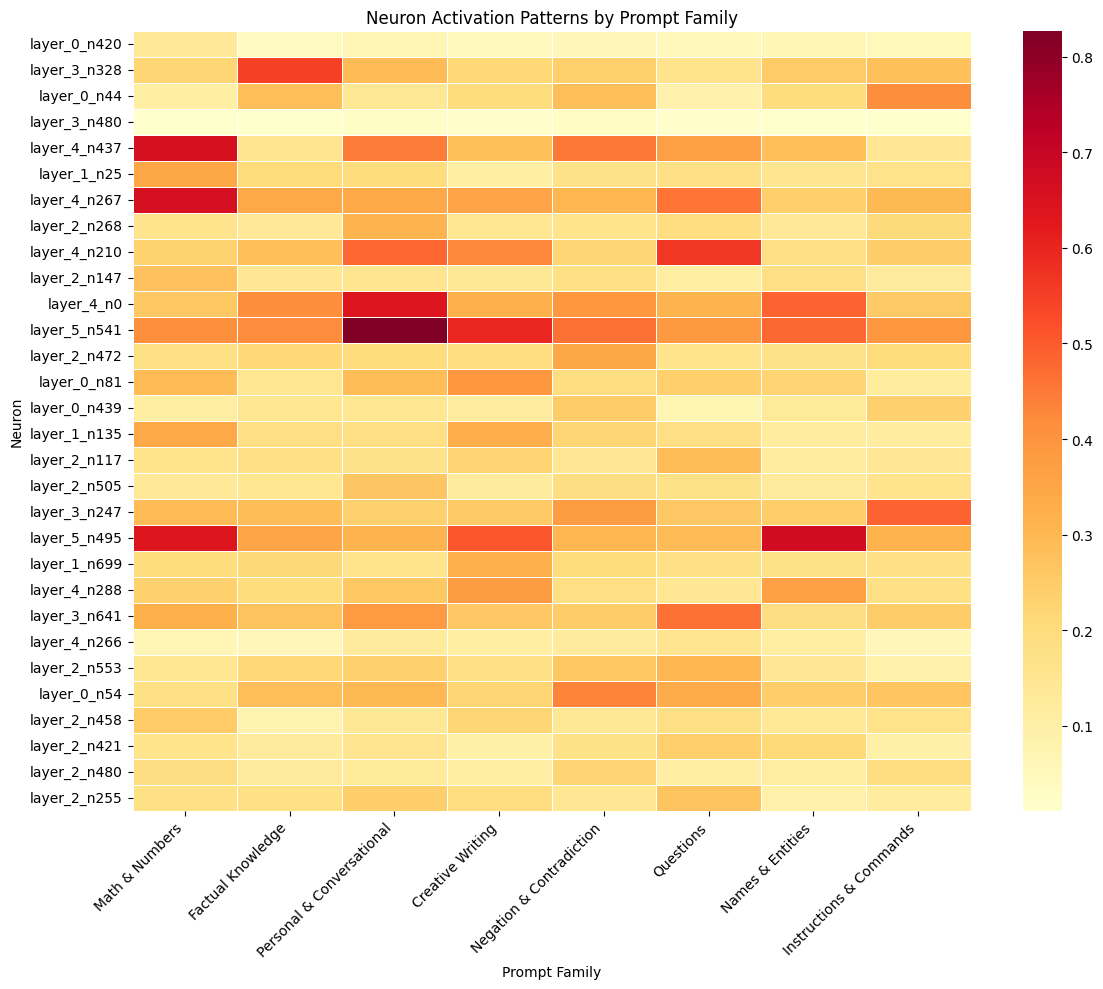


✓ Saved: neuron_family_heatmap.png

FINAL SUMMARY
✓ Total sparse neurons: 76
✓ Circuits discovered: 5
✓ Mean sparsity: 0.357
✓ Neurons with >1.5x selectivity: 30 (39.5%)

📊 Generated files:
  - sparsity_distribution.png
  - circuits_tsne.png
  - neuron_family_heatmap.png


In [ ]:
# Define prompt families
prompt_families = {
    "Math & Numbers": [
        "123 456 789", "5 + 7 = 12", "42 × 8 = 336", "234 + 567 = 801",
        "2, 4, 8, 16, 32", "$19.99 (25% off)", "-15.5°C or 4.1°F",
        "40.7128° N, 74.0060° W", "1010101 = 85 decimal", "3:4:5 ratio"
    ],
    "Factual Knowledge": [
        "Who was the first president?", "Capital of France?", "When did WWII end?",
        "Largest planet?", "Who wrote Romeo and Juliet?", "Chemical symbol for gold?",
        "How many continents?", "When did Titanic sink?", "Who invented telephone?",
        "Speed of light?"
    ],
    "Personal & Conversational": [
        "How are you today?", "What do you think?", "Can you help me?",
        "I'm feeling sad.", "Thank you so much!", "What's your favorite color?",
        "Tell me about yourself.", "I need advice.", "Do you like pizza?",
        "What makes you happy?"
    ],
    "Creative Writing": [
        "Once upon a time,", "The mysterious figure emerged,", "It was a dark night,",
        "In 2150, humanity had", "The dragon soared,", "She walked into the mansion,",
        "The secret garden was", "As the sun set,", "The detective examined,",
        "Magic filled the air"
    ],
    "Negation & Contradiction": [
        "This is not true.", "I don't think so.", "Never say never.",
        "Nobody knows nothing.", "Impossible to deny.", "Neither here nor there.",
        "That's not what I meant.", "Absolutely not.", "Can't disagree more.",
        "Nothing is not something."
    ],
    "Questions": [
        "Who? What? When? Where? Why?", "How does this work?", "Can you explain?",
        "What if we tried?", "Why would anyone?", "Is this the best way?",
        "Do you think it's possible?", "Which one should I choose?",
        "Where did you find that?", "How much does it cost?"
    ],
    "Names & Entities": [
        "Barack Obama visited Paris.", "Apple Inc. announced iPhone.",
        "Dr. Sarah Johnson published.", "Amazon River flows through Brazil.",
        "Microsoft CEO Satya Nadella.", "Tokyo is capital of Japan.",
        "Professor Einstein developed relativity.", "Mount Everest in Himalayas.",
        "Shakespeare wrote Hamlet.", "NASA launched SpaceX rocket."
    ],
    "Instructions & Commands": [
        "Write a grocery list.", "Translate to Spanish.", "Summarize this text.",
        "Create a schedule.", "Generate a recipe.", "Make a bullet list.",
        "Compare cats and dogs.", "Rewrite formally.", "Provide instructions.",
        "Format as table."
    ]
}

print(f"✓ Defined {len(prompt_families)} prompt families")

# Collect activations for each family
def collect_family_activations(prompts):
    family_acts = defaultdict(list)
    with torch.no_grad():
        for prompt in prompts:
            inputs = tokenizer(prompt, return_tensors="pt", truncation=True,
                             max_length=128, padding=True).to(device)
            temp_acts = {}
            temp_hooks = []

            def get_hook(layer_name):
                def hook(module, input, output):
                    temp_acts[layer_name] = output.mean(dim=1).detach().cpu()
                return hook

            for layer_idx in range(model.config.n_layer):
                layer_name = f"layer_{layer_idx}"
                hook = model.transformer.h[layer_idx].mlp.register_forward_hook(get_hook(layer_name))
                temp_hooks.append(hook)

            outputs = model(**inputs)
            for layer_name, acts in temp_acts.items():
                family_acts[layer_name].append(acts.numpy())
            for hook in temp_hooks:
                hook.remove()

    final_acts = {}
    for layer_name, acts_list in family_acts.items():
        final_acts[layer_name] = np.concatenate(acts_list, axis=0)
    return final_acts

all_family_activations = {}
for family_name, prompts in prompt_families.items():
    all_family_activations[family_name] = collect_family_activations(prompts)

print("✓ Collected activations for all families")

# Analyze patterns
results = []
for layer_name, neuron_info in sparse_neurons.items():
    for neuron_idx in neuron_info['indices']:
        neuron_data = {
            'layer': layer_name,
            'neuron_idx': neuron_idx,
            'sparsity': neuron_info['sparsity'][np.where(neuron_info['indices'] == neuron_idx)[0][0]]
        }
        for family_name, activations in all_family_activations.items():
            if layer_name in activations:
                neuron_acts = activations[layer_name][:, neuron_idx]
                neuron_data[f'{family_name}_mean'] = np.mean(np.abs(neuron_acts))
        results.append(neuron_data)

neuron_patterns_df = pd.DataFrame(results)
print(f"✓ Analyzed {len(neuron_patterns_df)} sparse neurons")

# Find specialized neurons
family_names = list(prompt_families.keys())
specialized_neurons = {}

for family in family_names:
    mean_col = f'{family}_mean'
    if mean_col in neuron_patterns_df.columns:
        neuron_patterns_df['differential'] = 0
        for idx, row in neuron_patterns_df.iterrows():
            this_act = row[mean_col]
            others = [row[f'{f}_mean'] for f in family_names if f != family and f'{f}_mean' in row]
            neuron_patterns_df.at[idx, 'differential'] = this_act - np.mean(others)

        top_neurons = []
        for idx, row in neuron_patterns_df.nlargest(5, 'differential').iterrows():
            this_act = row[mean_col]
            others = [row[f'{f}_mean'] for f in family_names if f != family and f'{f}_mean' in row]
            selectivity = this_act / np.mean(others) if np.mean(others) > 0 else 1
            top_neurons.append({
                'layer': row['layer'], 'neuron_idx': row['neuron_idx'],
                'activation': this_act, 'differential': row['differential'],
                'selectivity': selectivity, 'sparsity': row['sparsity']
            })
        specialized_neurons[family] = top_neurons

print("\n🎯 SPECIALIZED NEURONS BY PROMPT FAMILY:")
print("="*70)
for family_name, neurons in specialized_neurons.items():
    print(f"\n{family_name.upper()}:")
    for i, n in enumerate(neurons, 1):
        print(f"  {i}. {n['layer']} - Neuron {n['neuron_idx']}")
        print(f"     Activation: {n['activation']:.4f} | Differential: {n['differential']:+.4f}")
        print(f"     Selectivity: {n['selectivity']:.2f}x | Sparsity: {n['sparsity']:.3f}")

# Visualizations
neuron_selectivity = []
for idx, row in neuron_patterns_df.iterrows():
    activations = [row[f'{f}_mean'] for f in family_names if f'{f}_mean' in row]
    if activations:
        selectivity = max(activations) / np.mean(activations) if np.mean(activations) > 0 else 0
        neuron_selectivity.append((idx, selectivity, max(activations)))

neuron_selectivity.sort(key=lambda x: x[1], reverse=True)
top_indices = [x[0] for x in neuron_selectivity[:30]]

matrix = []
labels = []
for idx in top_indices:
    row = neuron_patterns_df.iloc[idx]
    labels.append(f"{row['layer']}_n{row['neuron_idx']}")
    matrix.append([row[f'{f}_mean'] for f in family_names])

plt.figure(figsize=(12, 10))
sns.heatmap(np.array(matrix), xticklabels=family_names, yticklabels=labels,
            cmap='YlOrRd', linewidths=0.5)
plt.title('Neuron Activation Patterns by Prompt Family')
plt.xlabel('Prompt Family')
plt.ylabel('Neuron')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig('neuron_family_heatmap.png', dpi=150, bbox_inches='tight')
plt.show()
print("\n✓ Saved: neuron_family_heatmap.png")

# Summary statistics
selective_counts = {}
for family in family_names:
    count = 0
    for idx, row in neuron_patterns_df.iterrows():
        activations = [row[f'{f}_mean'] for f in family_names if f'{f}_mean' in row]
        if activations and max(activations) > 0:
            selectivity = max(activations) / np.mean(activations)
            if selectivity >= 1.5 and activations.index(max(activations)) == family_names.index(family):
                count += 1
    selective_counts[family] = count

print("\n" + "="*70)
print("FINAL SUMMARY")
print("="*70)
print(f"✓ Total sparse neurons: {len(neuron_labels)}")
print(f"✓ Circuits discovered: {len(circuits)}")
print(f"✓ Mean sparsity: {all_sparsity.mean():.3f}")
print(f"✓ Neurons with >1.5x selectivity: {sum(selective_counts.values())} ({sum(selective_counts.values())/len(neuron_patterns_df)*100:.1f}%)")
print("\n📊 Generated files:")
print("  - sparsity_distribution.png")
print("  - circuits_tsne.png")
print("  - neuron_family_heatmap.png")